In [ ]:
# default_exp models.nbeats

In [ ]:
# hide
import sys

sys.path.append("..")

# N-Beats model

> A basic architecture for time series forecasting.


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export

def linspace(lookback, horizon):
    lin_space = torch.linspace(
        -lookback, horizon, lookback + horizon
    )
    b_ls = lin_space[:lookback]
    f_ls = lin_space[lookback:]
    return b_ls, f_ls


In [ ]:
# export
class Block(Module):
    def __init__(self, fnc_f, fnc_b=None):
        sizes = [self.lookback] + self.layers
        ps = ifnone(self.ps, L([0])*len(self.layers))
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=self.use_bn, p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps, actns))]
        self.layers = nn.Sequential(*_layers)
        
        if self.share_thetas:
            self.theta_f_fc = self.theta_b_fc = LinBnDrop(self.layers[-1], self.thetas_dim)
        else:
            self.theta_b_fc = LinBnDrop(sizes[-1], self.thetas_dim)
            self.theta_f_fc = LinBnDrop(sizes[-1], self.thetas_dim)
            
        b, f = linspace(self.lookback, self.horizon)
        self.backcast_linspace = Variable(b, requires_grad=False).to(self.device)
        self.forecast_linspace = Variable(f, requires_grad=False).to(self.device)
        self.fnc_f = fnc_f
        self.fnc_b = ifnone(fnc_b, fnc_f)
        self.to(self.device)
        self.y_range = getattr(self,'y_range', None)
        
    def forward(self, x):
        # trend
        x = self.layers(x)
        theta_b = self.apply_range(self.theta_b_fc(x))
        theta_f = self.apply_range(self.theta_f_fc(x))
        backcast = self.fnc_b(theta_b, self.backcast_linspace)
        forecast = self.fnc_f(theta_f, self.forecast_linspace)
        return {'b':backcast,'f': forecast, 'theta': theta_b + theta_f}
    
    def apply_range(self, x): 
        if self.y_range is None:
            return x
        return (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]

In [ ]:
# export
def bias_model(thetas, t):
    return t[None,:].float() * thetas

class BiasBlock(Block):
    def __init__(
        self, layers:L, device, thetas_dim=1, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False
    ):
        assert thetas_dim == 1, f"thetas_dim for BaisBlock must be 1, is now {thetas_dim}"
        store_attr(self,"device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        self.layers=L(self.layers[-1])
        super().__init__(bias_model)        
        self.to(device)

In [ ]:
mdl = BiasBlock([256], device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['theta'].shape,(64,1))

In [ ]:
# export
class LinearD(nn.Linear):        
    def forward(self, x, *args, **kwargs):
        return super().forward(x)
        
class GenericBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False, y_range=[-.5,.5]
    ):
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(LinearD(self.thetas_dim, self.horizon),LinearD(self.thetas_dim, self.lookback))        
        self.to(device)
        

In [ ]:
mdl = GenericBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))

In [ ]:
# export

def seasonality_model(thetas, t):
    p = thetas.size()[-1]
    assert p < 10, "thetas_dim is too big."
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = [torch.cos(2 * np.pi * i * t)[None,:] for i in range(p1)] # H/2-1
    s2 = [torch.sin(2 * np.pi * i * t)[None,:] for i in range(p2)]
    S = torch.cat([*s1, *s2])
    return thetas.mm(S)

class SeasonalityBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False,y_range=[-.5,.5]
    ):       
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(seasonality_model )        
        self.to(device)

In [ ]:
mdl = SeasonalityBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))

In [ ]:
# export
def trend_model(thetas, t):
    p = thetas.size()[-1]
    assert p <= 4, "thetas_dim is too big."
    a = [torch.pow(t, i)[None,:] for i in range(p)]
    T = torch.cat(a).float()
    return thetas.mm(T)

class TrendBlock(Block):
    def __init__(
        self, layers:L, device, thetas_dim, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False, y_range=[-.5,.5]
    ):
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(trend_model)        
        self.to(device)

In [ ]:
mdl = TrendBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['theta'].shape,(64,4))

In [ ]:
# export

# blocks= defaultdict(GenericBlock)
# blocks.update({"seasonality": SeasonalityBlock,
#          "trend": TrendBlock,
#          "generic": GenericBlock})
# blocks_int= {i:v for i,v in enumerate(blocks.items())}
# not pritty but still works better
def select_block(o):
    if isinstance(o,int):
        if o == 0:
            return SeasonalityBlock
        elif o == 1:
            return TrendBlock
        elif o == 2:
            return BaisBlock
        else:
            return GenericBlock
    else:
        if o == 'seasonality':
            return SeasonalityBlock
        elif o == 'trend':
            return TrendBlock
        elif o =='bias':
            return BiasBlock
        else:
            return GenericBlock

In [ ]:
# export
class NBeatsNet(Module):
    def __init__(
        self,
        device,
        stack_types=('bias', 'trend', 'bias', 'seaonality'),
        nb_blocks_per_stack=3,
        horizon=5,
        lookback=10,
        thetas_dim=(1, 3, 1, 3),
        share_weights_in_stack=True,
        layers= [200,100],
    ):
        super(NBeatsNet, self).__init__()
        store_attr(self,'device,horizon,lookback,layers,nb_blocks_per_stack,share_weights_in_stack,stack_types,thetas_dim,device')
        self.stacks = []
        self._str = "| N-Beats\n"
        
        self.bn = BatchNorm(lookback, ndim=2)        
        stacks = OrderedDict()        
        for stack_id in range(len(self.stack_types)):
            stacks[str(self.stack_types[stack_id]) + str(stack_id)] = self.create_stack(stack_id)
        self.stacks = nn.Sequential(stacks)
        
    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        self._str += f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})\n"
        
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    layers = self.layers,
                    thetas_dim = self.thetas_dim[stack_id],
                    device = self.device,
                    lookback = self.lookback,
                    horizon = self.horizon,
                )
            self._str += f"     | -- {block}\n"
            blocks.append(block)
            
        return nn.Sequential(*blocks)

    def forward(self, backcast):
        backcast = backcast.view([-1,backcast.shape[-1]])
        forecast = torch.zeros(
            size=(backcast.size()[0], self.horizon,)
        )  # maybe batch size here.
        
        dct = defaultdict(dict)
        for stack_id, names in enumerate(self.stacks.named_children()):
            name = names[0]
            for block_id in range(len(self.stacks[stack_id])):
                dct[name] = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - dct[name]['b']
                forecast = forecast.to(self.device) + dct[name]['f']
        return forecast[:,None,:], backcast[:,None,:], dct



In [ ]:
mdl = NBeatsNet(torch.device('cpu'), stack_types=('bias','seaonality','trend'))
f, b, dct = mdl(torch.randn(64,1,10))
print([o['theta'].mean(0) for k,o in dct.items()])
# dct['trend0']['theta'].mean(0), dct['trend0']['theta'].std(0)

[tensor([-0.0001], grad_fn=<MeanBackward1>), tensor([-0.0009, -0.0174,  0.0025], grad_fn=<MeanBackward1>), tensor([-0.0061], grad_fn=<MeanBackward1>)]


In [ ]:
# export
from fastai2.data.all import *
from fastai2.optimizer import *
from fastai2.learner import *

In [ ]:
# export
class NBeatsTrainer(Callback):
    "`Callback` that adds weights regularization the thetas in N-Beats training."
    def __init__(self, alpha=0., beta=0.): 
        self.alpha,self.beta = alpha,beta
        self.ratio = [0,0,0]

    def begin_train(self): 
        self.ratio = [0,0,0]   
        
    def begin_validate(self): 
        self.out = defaultdict(dict)
        self.ratio = [0,0,0] 
        
    def after_pred(self):
        if not self.training:
            self.out = concat_dct(self.pred[2], self.out)
        else:
            self.out = self.pred[2]
        self.learn.pred = self.pred[0]

    def after_loss(self):
        if not self.training: return
        self.ratio[0] += self.learn.loss.clone().detach()
        if self.alpha != 0.:     
            for key in self.out.keys():
                if 'bias' not in key:
                    self.learn.loss += self.alpha * self.out[key]['theta'].float().pow(2).sum()    
            self.ratio[1] += self.learn.loss.clone().detach()
        if self.beta != 0.:
            self.learn.loss += self.beta * self.loss(self.out['b'].float(), self.xb, reduction='mean')
            self.ratio[2] += self.learn.loss.clone().detach()
            


In [ ]:
# export
def CombinedLoss(*losses, ratio:dict=None):
    _ratio = defaultdict(lambda:1.)
    if ratio is not None:
        _ratio.update(ratio)    
    ratio = _ratio
    
    def _inner(pred, truth, *args,**kwargs):
        loss = None
        for _loss in losses:
            if loss is None:
                loss = ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs)
            else:
                loss += ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs)
        return loss
    
    return _inner
#     metrics = L()
#     for _loss in losses:
#         metrics.append(lambda pred, truth, *args,**kwargs: ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs))
#     print(metrics)
  

In [ ]:
y, y_hat = torch.arange(10).float(), torch.arange(10).float()+torch.randn(10)
loss_fnc = CombinedLoss(F.mse_loss,smape)
test_eq(F.mse_loss(y,y_hat)+smape(y,y_hat),loss_fnc(y, y_hat))

r = 10
loss_fnc = CombinedLoss(F.mse_loss, smape, ratio = {'mse_loss':r})
test_eq(r*F.mse_loss(y,y_hat)+smape(y,y_hat),loss_fnc(y, y_hat))


In [ ]:
# export
from fastai2.basics import *
from fastseq.all import *

@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataBunch, output_channels=None, metrics=None,cbs=None, alpha=0., beta=0., loss_func=None, **kwargs):
    "Build a N-Beats style learner"    
    model = NBeatsNet(
        device = dbunch.train_dl.device,
        horizon = dbunch.train_dl.horizon,
        lookback = dbunch.train_dl.lookback, 
        **kwargs
       )
#     model = model.to(dbunch.train_dl.device)
    loss_func = ifnone(loss_func, CombinedLoss(F.mse_loss, smape, ratio = {'smape':.0005}))
    learn = Learner(dbunch, model, loss_func=loss_func, opt_func= Adam, metrics=L(metrics)+L(mae, smape, F.mse_loss), cbs=L(NBeatsTrainer(alpha,beta))+L(cbs))
    return learn

Train:5000; Valid: 8000; Test 1000


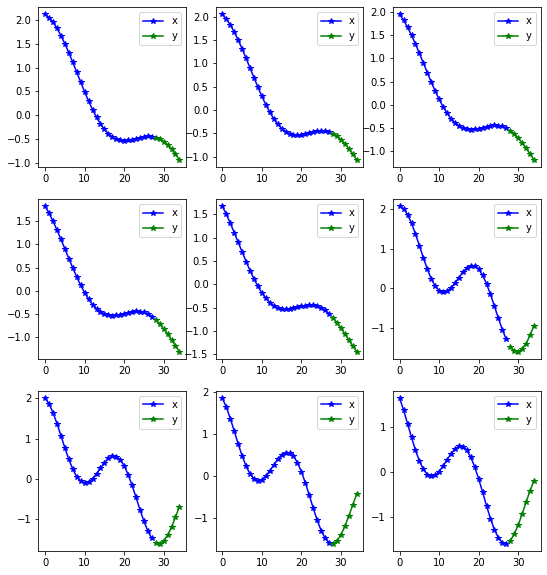

In [ ]:
from fastseq.data.external import *
items = dummy_data_generator(50, 10, nrows=1000)
data = TSDataBunch.from_items(items, horizon = 7)
data.show_batch()

In [ ]:
learn = nbeats_learner(data,layers=[200,200,100], alpha = 1, stack_types=('bias',"seasonality","trend"),
                       loss_func= CombinedLoss(F.mse_loss, smape, ratio = {'smape':.0001}),)

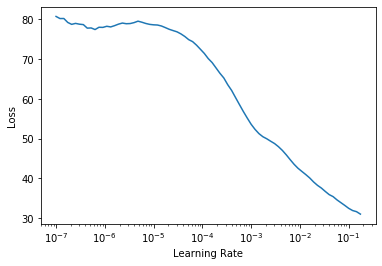

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mse_loss,time
0,7.320976,0.653796,0.499738,562.665405,0.372463,00:08
1,1.666415,0.556899,0.450979,525.342712,0.294228,00:08
2,0.646136,0.431777,0.359931,436.116791,0.213719,00:08
3,0.398405,0.484186,0.384441,425.163971,0.271604,00:08
4,0.343956,0.600340,0.453679,484.048431,0.358316,00:07
5,0.311664,0.556113,0.434152,468.697723,0.321764,00:08
6,0.279721,0.471856,0.386292,438.497467,0.252607,00:07
7,0.248776,0.529198,0.418991,467.160553,0.295617,00:07
8,0.217597,0.447889,0.364874,432.254211,0.231761,00:08
9,0.194634,0.432577,0.355808,421.161469,0.221997,00:07


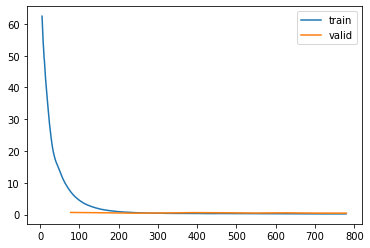

In [ ]:
learn.fit_one_cycle(10, 2e-3)
learn.recorder.plot_loss()

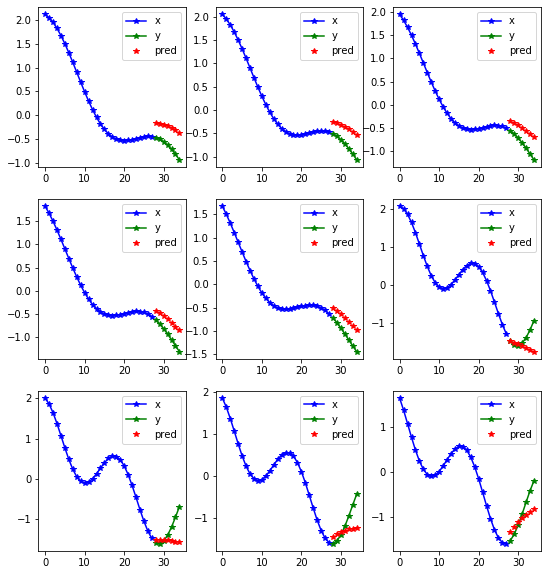

In [ ]:
learn.show_results(max_n=9)

In [ ]:
learn = nbeats_learner(data,layers=[200,200,100], alpha = 1, stack_types=('bias',"seasonality","trend"),
                       loss_func= CombinedLoss(F.mse_loss, smape, ratio = {'smape':.0001}))

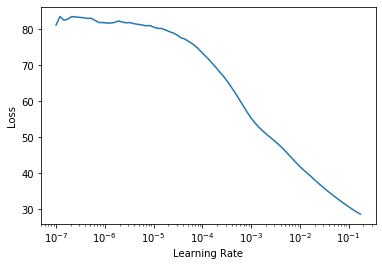

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mse_loss,time
0,7.683494,0.734293,0.638661,606.339722,0.673659,00:07
1,1.643005,0.738056,0.610272,568.111267,0.681245,00:08
2,0.575198,0.837478,0.641334,540.020081,0.783475,00:07
3,0.343567,1.078630,0.733369,559.830200,1.022647,00:07
4,0.280846,1.010476,0.705299,546.473755,0.955828,00:07
5,0.225083,1.010178,0.711883,559.338745,0.954244,00:07
6,0.187699,1.025816,0.726461,569.747070,0.968841,00:07
7,0.156860,0.917785,0.673772,535.593140,0.864226,00:07
8,0.130279,0.821048,0.625223,524.164612,0.768632,00:07
9,0.116552,0.797709,0.610299,500.320282,0.747677,00:08


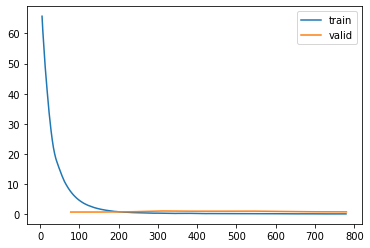

In [ ]:
learn.fit_one_cycle(10, 2e-3)
learn.recorder.plot_loss()

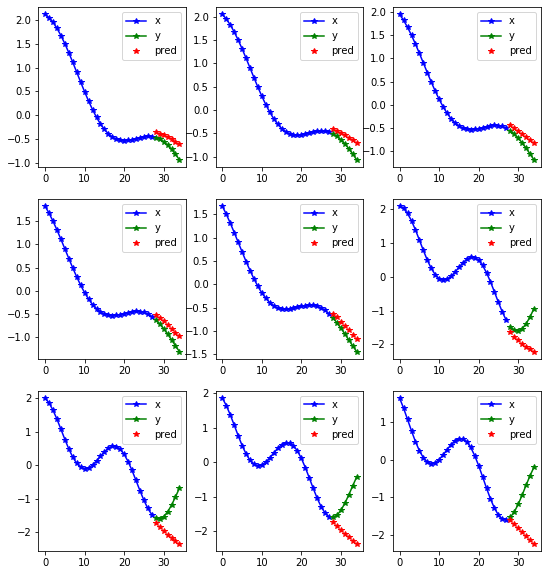

In [ ]:
learn.show_results(max_n=9)

In [ ]:
# hide
_ = learn.get_preds(dl=learn.dbunch.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)
l_dct = learn.n_beats_trainer.out

In [ ]:
# hide
print([(k,o['theta'].mean(0).data.detach().cpu()) for k,o in l_dct.items()])

[('bias0', tensor([-0.0504])), ('seasonality1', tensor([ 0.0002, -0.0031,  0.0009])), ('trend2', tensor([0.0009]))]


In [ ]:
# hide
print(learn.summary())

NBeatsNet (Input shape: ['64 x 1 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 28              56         True      
________________________________________________________________
Linear               64 x 100             2,800      True      
________________________________________________________________
BatchNorm1d          64 x 100             200        True      
________________________________________________________________
Linear               64 x 1               100        True      
________________________________________________________________
BatchNorm1d          64 x 100             200        True      
________________________________________________________________
Linear               64 x 1               100        True      
________________________________________________________________
BatchNorm1d          64 x 28              56         True      
_________________________________________________________

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 07_interpret.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 10_models.nbeats.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
